# Emotions classifier 

## Project scope

<p>The scope of this project is to create a classifier of human emotion expressed through text obtained from publicly available tweets. </p>

## Imports

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import contractions

# Exploratory data analysis

<p>Let's get to actually know our data and determine what we'll have to do with it in the preprocessing section, before we can proceed to training a classifier model on it.</p>

In [3]:
tweets_data = pd.read_csv('./Data/tweet_emotions.csv')

In [4]:
tweets_data.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


<p>I see we'll have to deal with special characters, elongated leters, inaccurate grammar, etc. Let's see how big is the dataset. </p>

In [5]:
tweets_data.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


<p>Ok, we have 40000 records inside of our dataset, which means that we'll have to, eventually, break down the preprocessing iterative part into batches of smaller data, so that it all gets done quickly and less costly in terms of memory and processing power. </p>

<p>Let's see all of our sentiment classes, this is what we'll train our model to predict based on an input text.</p>

In [8]:
tweets_data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

<p>Ok, apparently we'll have to do multi-class classification, so logistic regression is out of the question for our classification model. Perhaps we could use K-Nearest Neighbour or a naive bayes classifier? Maybe even a random forest one? </p>

<p>We should also see if our dataset, in terms of sentiments, is balanced i.e. if the dataset does not contain mostly enthusiasm or some other sentiment. </p>

<AxesSubplot: >

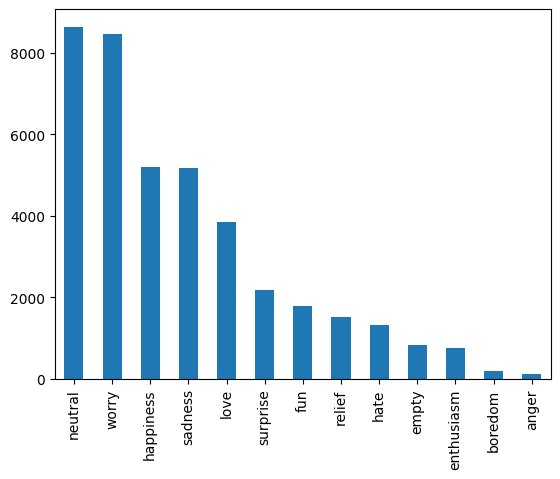

In [28]:
tweets_data['sentiment'].value_counts().plot(kind='bar')

<p>Obviously the model, with the current data, will be incredibly biased toward neutral and worry emotions because they make up most of the dataset. That's a problem we have to deal with. One way we could do that is to duplicate the lower values until they get up to the scale of the neutral and worry sentiments? Another one, which to me seems a lot more practical, is to use weighted loss for the classification model. Basically, we'll use scikit learn and tell it to assign a weight to all the sentiments that is inversely proportional to the sentiment's frequency in the dataset.</p>

# Data preprocessing

<p> First, we'll have to seperate the tweets into words, and then remove the stopwords and make all the words lower case, so that we don't get any unpleasant surprises later on. </p>

In [34]:
tweets = tweets_data['content']

In [68]:
words_tokenized_tweets = [word_tokenize(tweet_sentence) for tweet_sentence in tweets]

In [70]:
words_tokenized_tweets[0:10]

[['@',
  'tiffanylue',
  'i',
  'know',
  'i',
  'was',
  'listenin',
  'to',
  'bad',
  'habit',
  'earlier',
  'and',
  'i',
  'started',
  'freakin',
  'at',
  'his',
  'part',
  '=',
  '['],
 ['Layin',
  'n',
  'bed',
  'with',
  'a',
  'headache',
  'ughhhh',
  '...',
  'waitin',
  'on',
  'your',
  'call',
  '...'],
 ['Funeral', 'ceremony', '...', 'gloomy', 'friday', '...'],
 ['wants', 'to', 'hang', 'out', 'with', 'friends', 'SOON', '!'],
 ['@',
  'dannycastillo',
  'We',
  'want',
  'to',
  'trade',
  'with',
  'someone',
  'who',
  'has',
  'Houston',
  'tickets',
  ',',
  'but',
  'no',
  'one',
  'will',
  '.'],
 ['Re-pinging',
  '@',
  'ghostridah14',
  ':',
  'why',
  'did',
  "n't",
  'you',
  'go',
  'to',
  'prom',
  '?',
  'BC',
  'my',
  'bf',
  'did',
  "n't",
  'like',
  'my',
  'friends'],
 ['I',
  'should',
  'be',
  'sleep',
  ',',
  'but',
  'im',
  'not',
  '!',
  'thinking',
  'about',
  'an',
  'old',
  'friend',
  'who',
  'I',
  'want',
  '.',
  'but',
  'he

In [100]:
no_stopwords = [[word.lower() for word in tweet if word not in set(stopwords.words('english'))] for tweet in words_tokenized_tweets ]

In [102]:
no_stopwords[0]

['@',
 'tiffanylue',
 'know',
 'listenin',
 'bad',
 'habit',
 'earlier',
 'started',
 'freakin',
 'part',
 '=',
 '[']

<p>It seems to be working, no stopwords seem to be present here. Now, let's remove anything that's not a word (I assume that excalamation and question marks do not show that much of an emotion as the individual words used in the context of the entire tweet). We'll use a regex for that. </p>

In [106]:
words_only_sentences = [[word for word in tweet if not re.match('\W+|\d+', word) ] for tweet in no_stopwords ]

In [108]:
words_only_sentences[0:5]

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'started',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['wants', 'hang', 'friends', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'tickets',
  'one']]

<p> It seems to have worked, now we have to take care of the so called contraction words, such as: don't, can't, won't, etc. We'll expand them like so: don't - do not, can't - cannot, etc. </p>

In [110]:
words_only_sentences = [[contractions.fix(word) for word in tweet] for tweet in words_only_sentences ]

In [111]:
words_only_sentences

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'started',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['wants', 'hang', 'friends', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'tickets',
  'one'],
 ['re-pinging',
  'ghostridah14',
  "n't",
  'go',
  'prom',
  'because',
  'bf',
  "n't",
  'like',
  'friends'],
 ['i',
  'sleep',
  'i am',
  'thinking',
  'old',
  'friend',
  'i',
  'want',
  'married',
  'damn',
  'amp',
  'wants',
  'scandalous'],
 ['hmmm', 'http'],
 ['charviray', 'charlene', 'love', 'i', 'miss'],
 ['kelcouch', 'i', 'sorry', 'least', 'friday'],
 ['cannot', 'fall', 'asleep'],
 ['choked', 'retainers'],
 ['ugh', 'i', 'beat', 'stupid', 'song', 'get', 'next', 'rude'],
 ['brodyjenner',
  'you',
  'watch',
  'hills',
  'london',
  'you',
  'realise',
  'tourture',
  'weeks',
  'weeks',
  'late',
  'watch',
  'itonlinelo

<p> I think we're ready with the preprocessing, we've achieved what we set out to achieve earlier in this section. Let's move on to the models building.</p>

# Models buidling